# UDI Grammar Workflow Demo

This notebook demonstrates a complete workflow for visualizing DICOM metadata using the UDI grammar system.

**Workflow steps:**
1. Extract DICOM metadata from a directory of .dcm files and save selected attributes to a CSV file.
2. Load the CSV in Python and generate a UDI grammar specification for a bar chart (with faceting by Modality).
3. Render the UDI grammar spec to a PNG image and display it in the notebook.

---

## Step 1: Extract DICOM Metadata to CSV
 We use the `extract_usecase_columns` function from our DICOM metadata utility.
This function scans a directory for DICOM (.dcm) files, extracts a set of interesting metadata fields (such as PatientAge, Modality, Manufacturer, etc.), and writes them to a CSV file.

This CSV will be used as the data source for visualization in later steps.

In [9]:
from read_dicom_metadata import extract_usecase_columns

dicom_dir = '/Users/chunwei/research/midrc-demo/downloads'
csv_path = 'usecase_col.csv'
extract_usecase_columns(dicom_dir, csv_path)
print(f'CSV written to {csv_path}')

Wrote selected metadata for 33 DICOM files to usecase_col.csv
CSV written to usecase_col.csv


## Step 2: Generate a UDI Grammar Specification

We now load the CSV and use the `udi-grammar-py` library to build a UDI grammar specification for a bar chart.

- **X-axis:** PatientAge (nominal)
- **Y-axis:** Count of records
- **Color:** PatientSex
- **Facet (column):** Modality

We patch the rollup part of the spec to ensure it is valid for the UDI grammar web app, and add the column encoding manually for faceting.

The resulting spec can be used in the UDI web editor or for automated rendering.

In [10]:
from udi_grammar_py.spec import Chart
from udi_grammar_py.helpers import Op
import json

def make_udi_spec(csv_path):
    chart = (
        Chart()
        .source('dicom', csv_path)
        .groupby(['PatientAge', 'Modality', 'PatientSex'])
        .rollup('count', count=Op.count())
        .mark('bar')
        .x(field='PatientAge', type='nominal')
        .y(field='count', type='quantitative')
        .color(field='PatientSex', type='nominal')
    )
    spec = chart.to_dict()
    for t in spec['transformation']:
        if 'rollup' in t and isinstance(t['rollup'], str):
            t['rollup'] = {'count': {'op': 'count'}}
    # Add column encoding manually for faceting by Modality
    spec['representation']['mapping'].append({
        'encoding': 'column',
        'field': 'Modality',
        'type': 'nominal'
    })
    return spec
csv_path_s3 = "https://neural-science.s3.us-east-1.amazonaws.com/usecase_col.csv"
udi_spec = make_udi_spec(csv_path_s3)
print(json.dumps(udi_spec, indent=2))

{
  "source": {
    "name": "dicom",
    "source": "https://neural-science.s3.us-east-1.amazonaws.com/usecase_col.csv"
  },
  "transformation": [
    {
      "groupby": [
        "PatientAge",
        "Modality",
        "PatientSex"
      ]
    },
    {
      "rollup": {
        "count": {
          "op": "count"
        }
      }
    }
  ],
  "representation": {
    "mark": "bar",
    "mapping": [
      {
        "encoding": "x",
        "field": "PatientAge",
        "type": "nominal"
      },
      {
        "encoding": "y",
        "field": "count",
        "type": "quantitative"
      },
      {
        "encoding": "color",
        "field": "PatientSex",
        "type": "nominal"
      },
      {
        "encoding": "column",
        "field": "Modality",
        "type": "nominal"
      }
    ]
  }
}


## Step 3: Render the UDI Spec to an Image

We use the `udi_to_png` function to render the UDI grammar spec to a PNG image.
This function launches a headless browser, loads the UDI web editor with the spec, and downloads the resulting chart as a PNG.

We then display the image directly in the notebook.

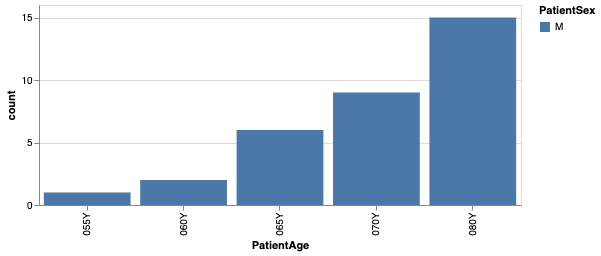

In [11]:
import asyncio
from udi_grammar_wrapper import udi_to_png
from IPython.display import Image, display

output_img = 'udi_chart.png'
# Render the image (Jupyter supports top-level await)
await udi_to_png(udi_spec, output_img)
display(Image(output_img))

---

## An Interactive Option: UDI Web Interface in Notebook

You can interactively explore and edit UDI grammar specifications using the official UDI web editor, embedded below.

**How to use:**
- Copy the generated UDI spec from Python (see above) and paste it into the editor's text box.
- The visualization will update automatically.
- You can also edit the spec directly in the web interface.

---

In [12]:
from IPython.display import HTML
HTML("<iframe src='https://hms-dbmi.github.io/udi-grammar/#/Editor' width='1200' height='1000'></iframe>")